# Libs

In [1]:
from skimage.data import lfw_subset
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import hessian_matrix
import matplotlib.patches as patches

from skimage import transform, io
from scipy.ndimage import maximum_filter,minimum_filter
from scipy.ndimage import gaussian_filter
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

# Dataset

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


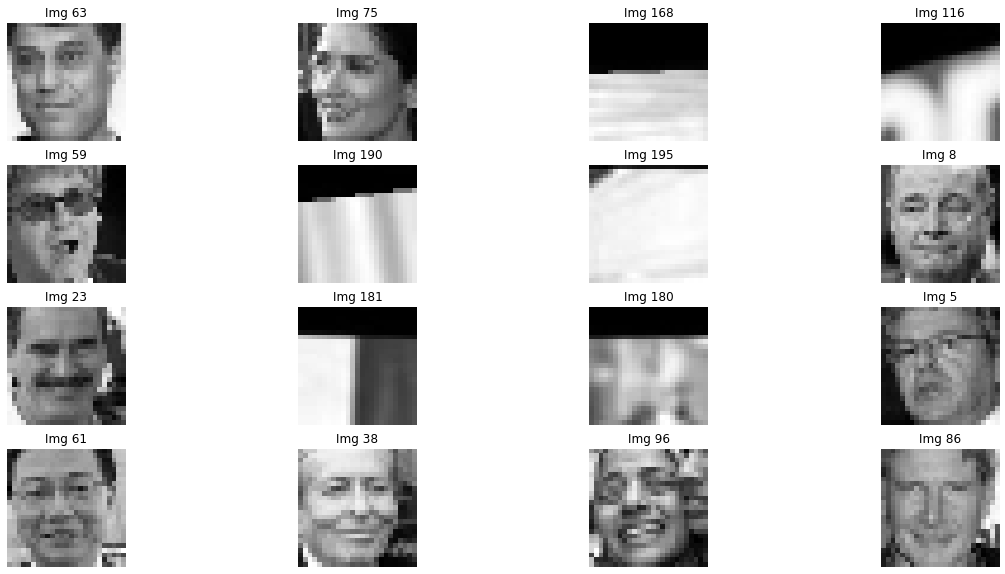

In [2]:
data = lfw_subset()

fig, axs = plt.subplots(4, 4,figsize=(20,10))
sample = np.random.randint(0,data.shape[0],16)

for i in range(16):
    idx = sample[i]
    im  = data[idx,:,:]
    rr = i//4
    cc = i%4
    axs[rr,cc].imshow(im,cmap='gray')
    axs[rr,cc].axis('off')
    axs[rr,cc].set_title("Img {}".format(idx))

# Integral image

$GreenSquare = D + A - B - C$

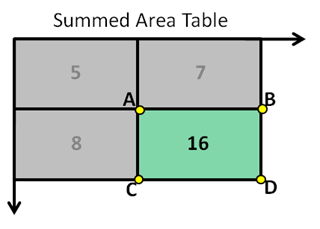

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[ 1.  2.  3.  4.  5.]
 [ 2.  4.  6.  8. 10.]
 [ 3.  6.  9. 12. 15.]
 [ 4.  8. 12. 16. 20.]
 [ 5. 10. 15. 20. 25.]]
(25, 25)


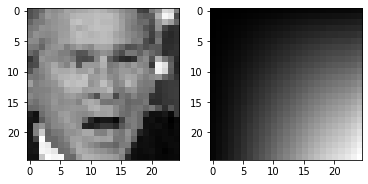

In [7]:
print(np.ones((5, 5)))
print(np.cumsum(np.cumsum(np.ones((5, 5)),axis=0),axis=1))
print(img.shape)

img = data[0,:,:]
integral_img = np.cumsum(np.cumsum(im,axis=0),axis=1)
plt.subplot(121)
plt.imshow(img,cmap="gray")
plt.subplot(122)
plt.imshow(integral_img, cmap="gray")


In [10]:
train_set = np.concatenate((data[0:50,...],data[100:150,...]))
test_set = np.concatenate((data[50:100,...],data[150:200,...]))

print(train_set.shape)
print(test_set.shape)

(100, 25, 25)
(100, 25, 25)


# Haar features

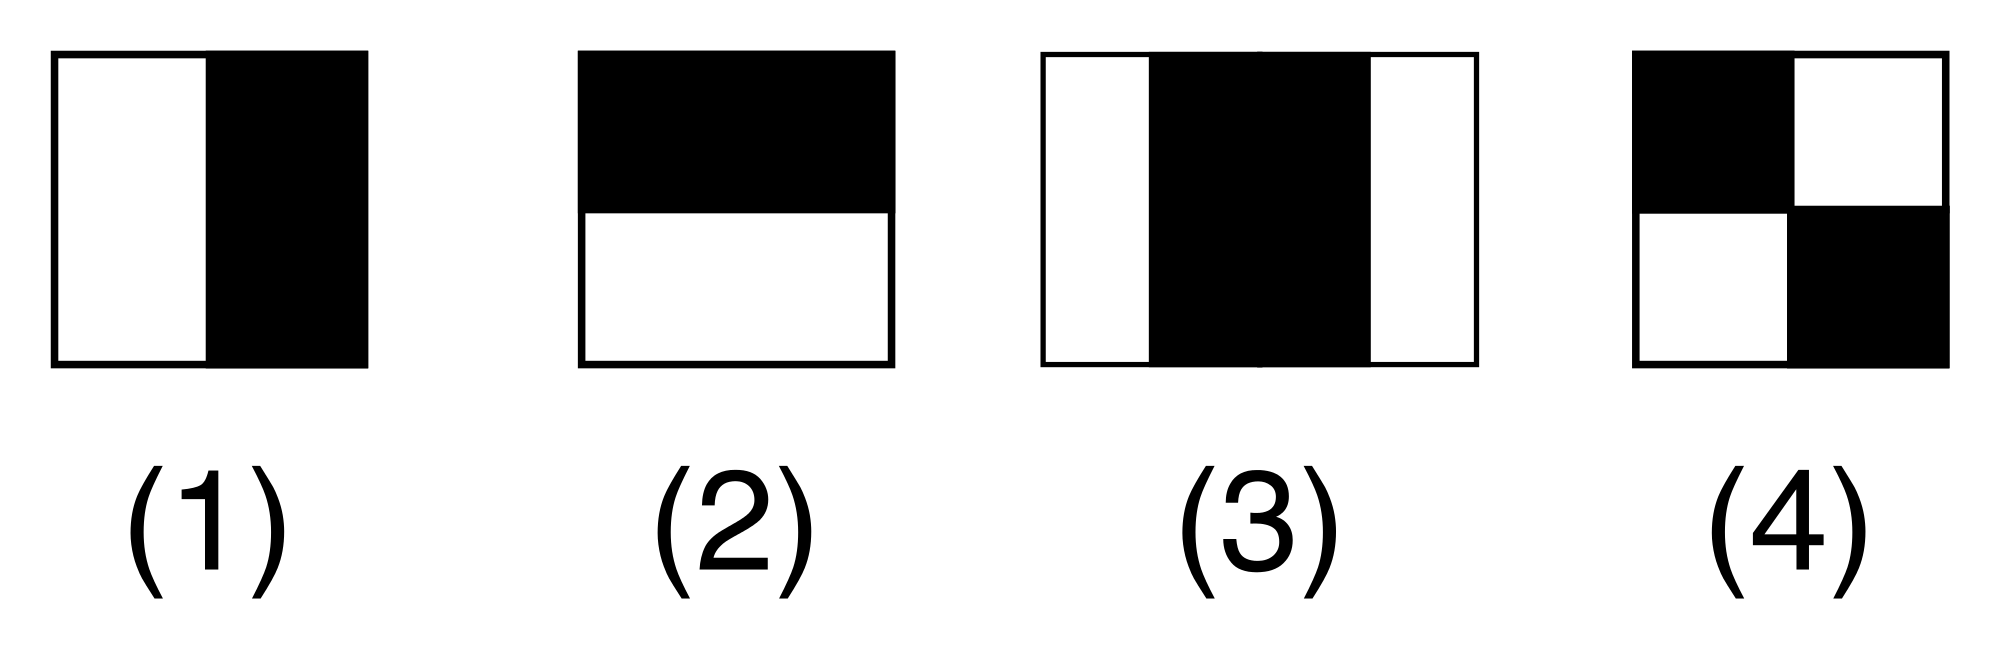

## Implementation of (2) feature

In [43]:
def getHaarFeatures2(train_set,img_shape):
    features = np.zeros(shape=(100,(img_shape[0]-6)*(img_shape[1]-2)))

    for i in range(train_set.shape[0]):
        img = train_set[i,...]
        integral_img = np.cumsum(np.cumsum(img,axis=0),axis=1)
        it = 0
        for rr in range(img_shape[0]-6):
            for cc in range(img_shape[1]-2):
                rect_sum_black = integral_img[rr+3,cc+2] + integral_img[rr,cc] - integral_img[rr,cc+2] - integral_img[rr+3,cc]
                rect_sum_white = integral_img[rr+6,cc+2] + integral_img[rr+3,cc] - integral_img[rr+6,cc]  - integral_img[rr+3,cc+2]
                haar = -rect_sum_black + rect_sum_white
                features[i,it] = haar
                it = it +1
    print(features.shape)
    return features


## Implementation of (4) feature

In [34]:

def getHaarFeatures4(train_set,img_shape):
    features = np.zeros(shape=(100,(img_shape[0]-4)*(img_shape[1]-4)))

    for i in range(train_set.shape[0]):
        img = train_set[i,...]
        integral_img = np.cumsum(np.cumsum(img,axis=0),axis=1)
        it = 0
        for rr in range(img_shape[0]-4):
            for cc in range(img_shape[1]-4):
                left_sum_black = integral_img[rr+2,cc+2] + integral_img[rr,cc] - integral_img[rr,cc+2] - integral_img[rr+2,cc];
                right_sum_black = integral_img[rr+4,cc+4] + integral_img[rr+2,cc+2] - integral_img[rr+2,cc+4] - integral_img[rr+4,cc+2];
                left_sum_white = integral_img[rr+4,cc+2] + integral_img[rr+2,cc] - integral_img[rr+2,cc+2] - integral_img[rr+4,cc];
                right_sum_white = integral_img[rr+2,cc+4] + integral_img[rr,cc+2] - integral_img[rr,cc+4] - integral_img[rr+2,cc+2];
                haar = -left_sum_black  -right_sum_black +left_sum_white +right_sum_white
                features[i,it] = haar
                it = it +1
    return features

# Adaboost training

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
features = getHaarFeatures2(train_set,img.shape)
clf = AdaBoostClassifier(n_estimators=400, random_state=0)
Y = np.concatenate((np.ones((50,)),np.zeros((50,))))
clf.fit(features, Y)
print(clf.score(features, Y))

(100, 437)
1.0


1.0


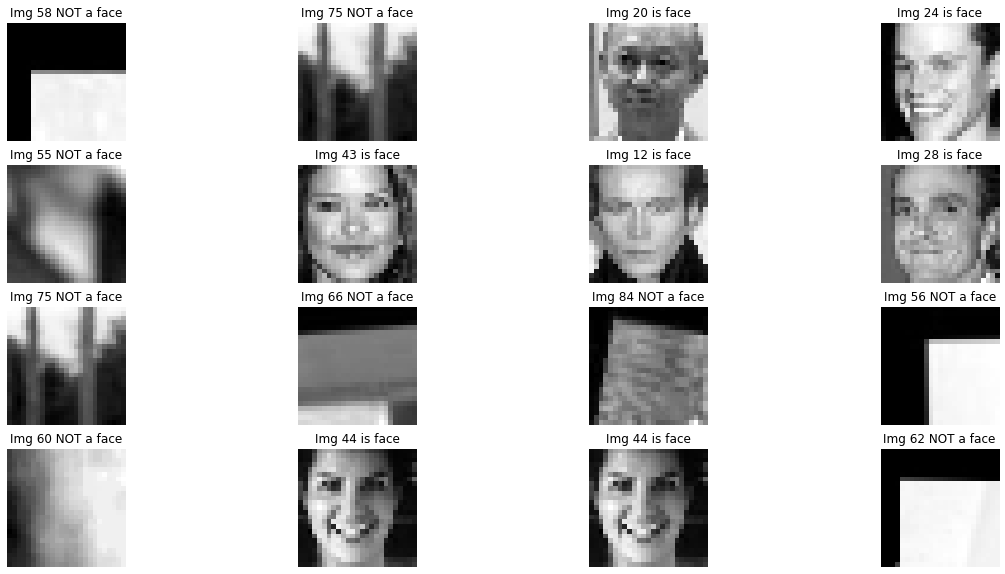

In [36]:
clf.fit(features, Y)

print(clf.score(features, Y))
Y_pred = clf.predict(features)

fig, axs = plt.subplots(4, 4,figsize=(20,10))
sample = np.random.randint(0,test_set.shape[0],16)

for i in range(16):
    idx = sample[i]
    im  = test_set[idx,:,:]
    rr = i//4
    cc = i%4
    axs[rr,cc].imshow(im,cmap='gray')
    axs[rr,cc].axis('off')
    if (Y_pred[idx] == 1):
        axs[rr,cc].set_title("Img {} is face".format(idx))
    else:
        axs[rr,cc].set_title("Img {} NOT a face".format(idx))

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


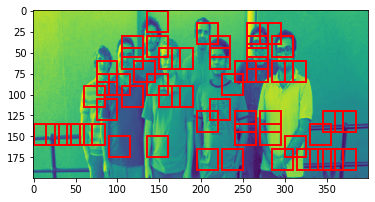

In [45]:
img_orig = transform.resize(rgb2gray(io.imread("/content/drive/MyDrive/faces.jpg")),(200,400))
img_faces = np.cumsum(np.cumsum(img_orig,axis=0),axis=1)
# Create figure and axes
fig, ax = plt.subplots()
ax.imshow(img_orig)
step = 15

for i in np.arange(0,img_faces.shape[0]-25,step):
    for j in np.arange(0,img_faces.shape[1]-25,step):

        integral_img = img_faces[i:i+25,j:j+25]
        haar_features = np.zeros(shape=(1,(img.shape[0]-6)*(img.shape[1]-2)))
        it = 0

        for rr in range(img.shape[0]-6):
            for cc in range(img.shape[1]-2):
                rect_sum_black = integral_img[rr+3,cc+2] + integral_img[rr,cc] - integral_img[rr,cc+2] - integral_img[rr+3,cc]
                rect_sum_white = integral_img[rr+6,cc+2] + integral_img[rr+3,cc] - integral_img[rr+6,cc]  - integral_img[rr+3,cc+2]

                haar = - rect_sum_black + rect_sum_white
                haar_features[0,it] = haar
                it = it +1

        Y_pred = clf.predict(haar_features)

        if Y_pred ==1:
            rect = patches.Rectangle((j, i), 25, 25, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [ ]:

def return_sum_of_area(integral_img, rr, cc, hh, ww):
    area_sum = integral_img[rr+hh,cc+ww] + integral_img[rr,cc] \
                      - integral_img[rr,cc+ww] - integral_img[rr+hh,cc]
    return area_sum

In [ ]:
test_integral_img  = np.cumsum(np.cumsum(np.ones((5, 5)),axis=0),axis=1)

print(return_sum_of_area(test_integral_img,0,0,2,2))

print(return_sum_of_area(test_integral_img,1,1,2,2))

print(return_sum_of_area(test_integral_img,0,0,4,4))

4.0
4.0
16.0


In [ ]:
def edge_feature(integral_img, rr, cc, hh, ww, isVertical=True):
    N=hh//2*ww//2
    if isVertical:
        sum_white =  return_sum_of_area(integral_img,rr,cc,hh,ww//2)
        sum_black =  return_sum_of_area(integral_img,rr,cc+ww//2,hh,ww//2)
        return sum_white/N-sum_black/N
    else:
        sum_white =  return_sum_of_area(integral_img,rr,cc,hh//2,ww)
        sum_black =  return_sum_of_area(integral_img,rr+hh//2,cc,hh//2,ww)
        return sum_white/N-sum_black/N

In [ ]:
def line_feature(integral_img, rr, cc, hh, ww, isVertical=True):
        N_w=hh//2*ww//2
        N_b=hh//4*ww//4

        if isVertical:
            sum_white1 =  return_sum_of_area(integral_img,rr,cc,hh,ww//4)
            sum_black1 =  return_sum_of_area(integral_img,rr,cc+ww//4,hh,ww//2)
            sum_white2 =  return_sum_of_area(integral_img,rr,cc+(3*(ww//4)),hh,ww//4)

            return sum_white1/N_w-sum_black1/N_b +sum_white2/N_w
        else:
            sum_white1 =  return_sum_of_area(integral_img,rr,cc,hh//4,ww)
            sum_black1 =  return_sum_of_area(integral_img,rr+hh//4,cc,hh//2,ww)
            sum_white2 =  return_sum_of_area(integral_img,rr+(3*(hh//4)),cc,hh//4,ww)

            return sum_white1/N_w-sum_black1/N_b +sum_white2/N_w

In [ ]:
def resize_stack(stack,out_shape):
    out_stack = np.empty((stack.shape[0],out_shape[0],out_shape[1]))
    for i, image in zip(range(stack.shape[0]),stack):
        out_stack[i,...] = transform.resize(image,out_shape)
    return out_stack

In [ ]:

from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people

lfw_subset_data = lfw_subset()
lfw_subset_norm = lfw_subset_data/255

img_stack = np.array([])
lfw_people = fetch_lfw_people(min_faces_per_person=1)
imgs_resized = resize_stack(lfw_people.images/255,(25,25))

import torch
import torchvision
torch.manual_seed(17)

data_transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                                    torchvision.transforms.Resize(size=(25,25)),
                                    torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.CIFAR10("/",transform=data_transform,download=True)

imgs_cifar = np.zeros((10000,25,25))

idx = np.random.randint(0,len(dataset),10000)
for i in range(10000):
    im,_ = dataset.__getitem__(idx[i])
    imgs_cifar[i,:,:] = np.squeeze(im.cpu().detach().numpy())

Files already downloaded and verified


In [ ]:
data_faces = np.concatenate((lfw_subset_norm[0:100,...],imgs_resized[0:10000,...]))
data_non_faces = np.concatenate((lfw_subset_norm[100:200,...],imgs_cifar[0:10000,...]))

In [ ]:
dataset = np.concatenate((data_faces,data_non_faces))
Y_dataset = np.concatenate((np.ones((10100,)),np.zeros((10100,))))

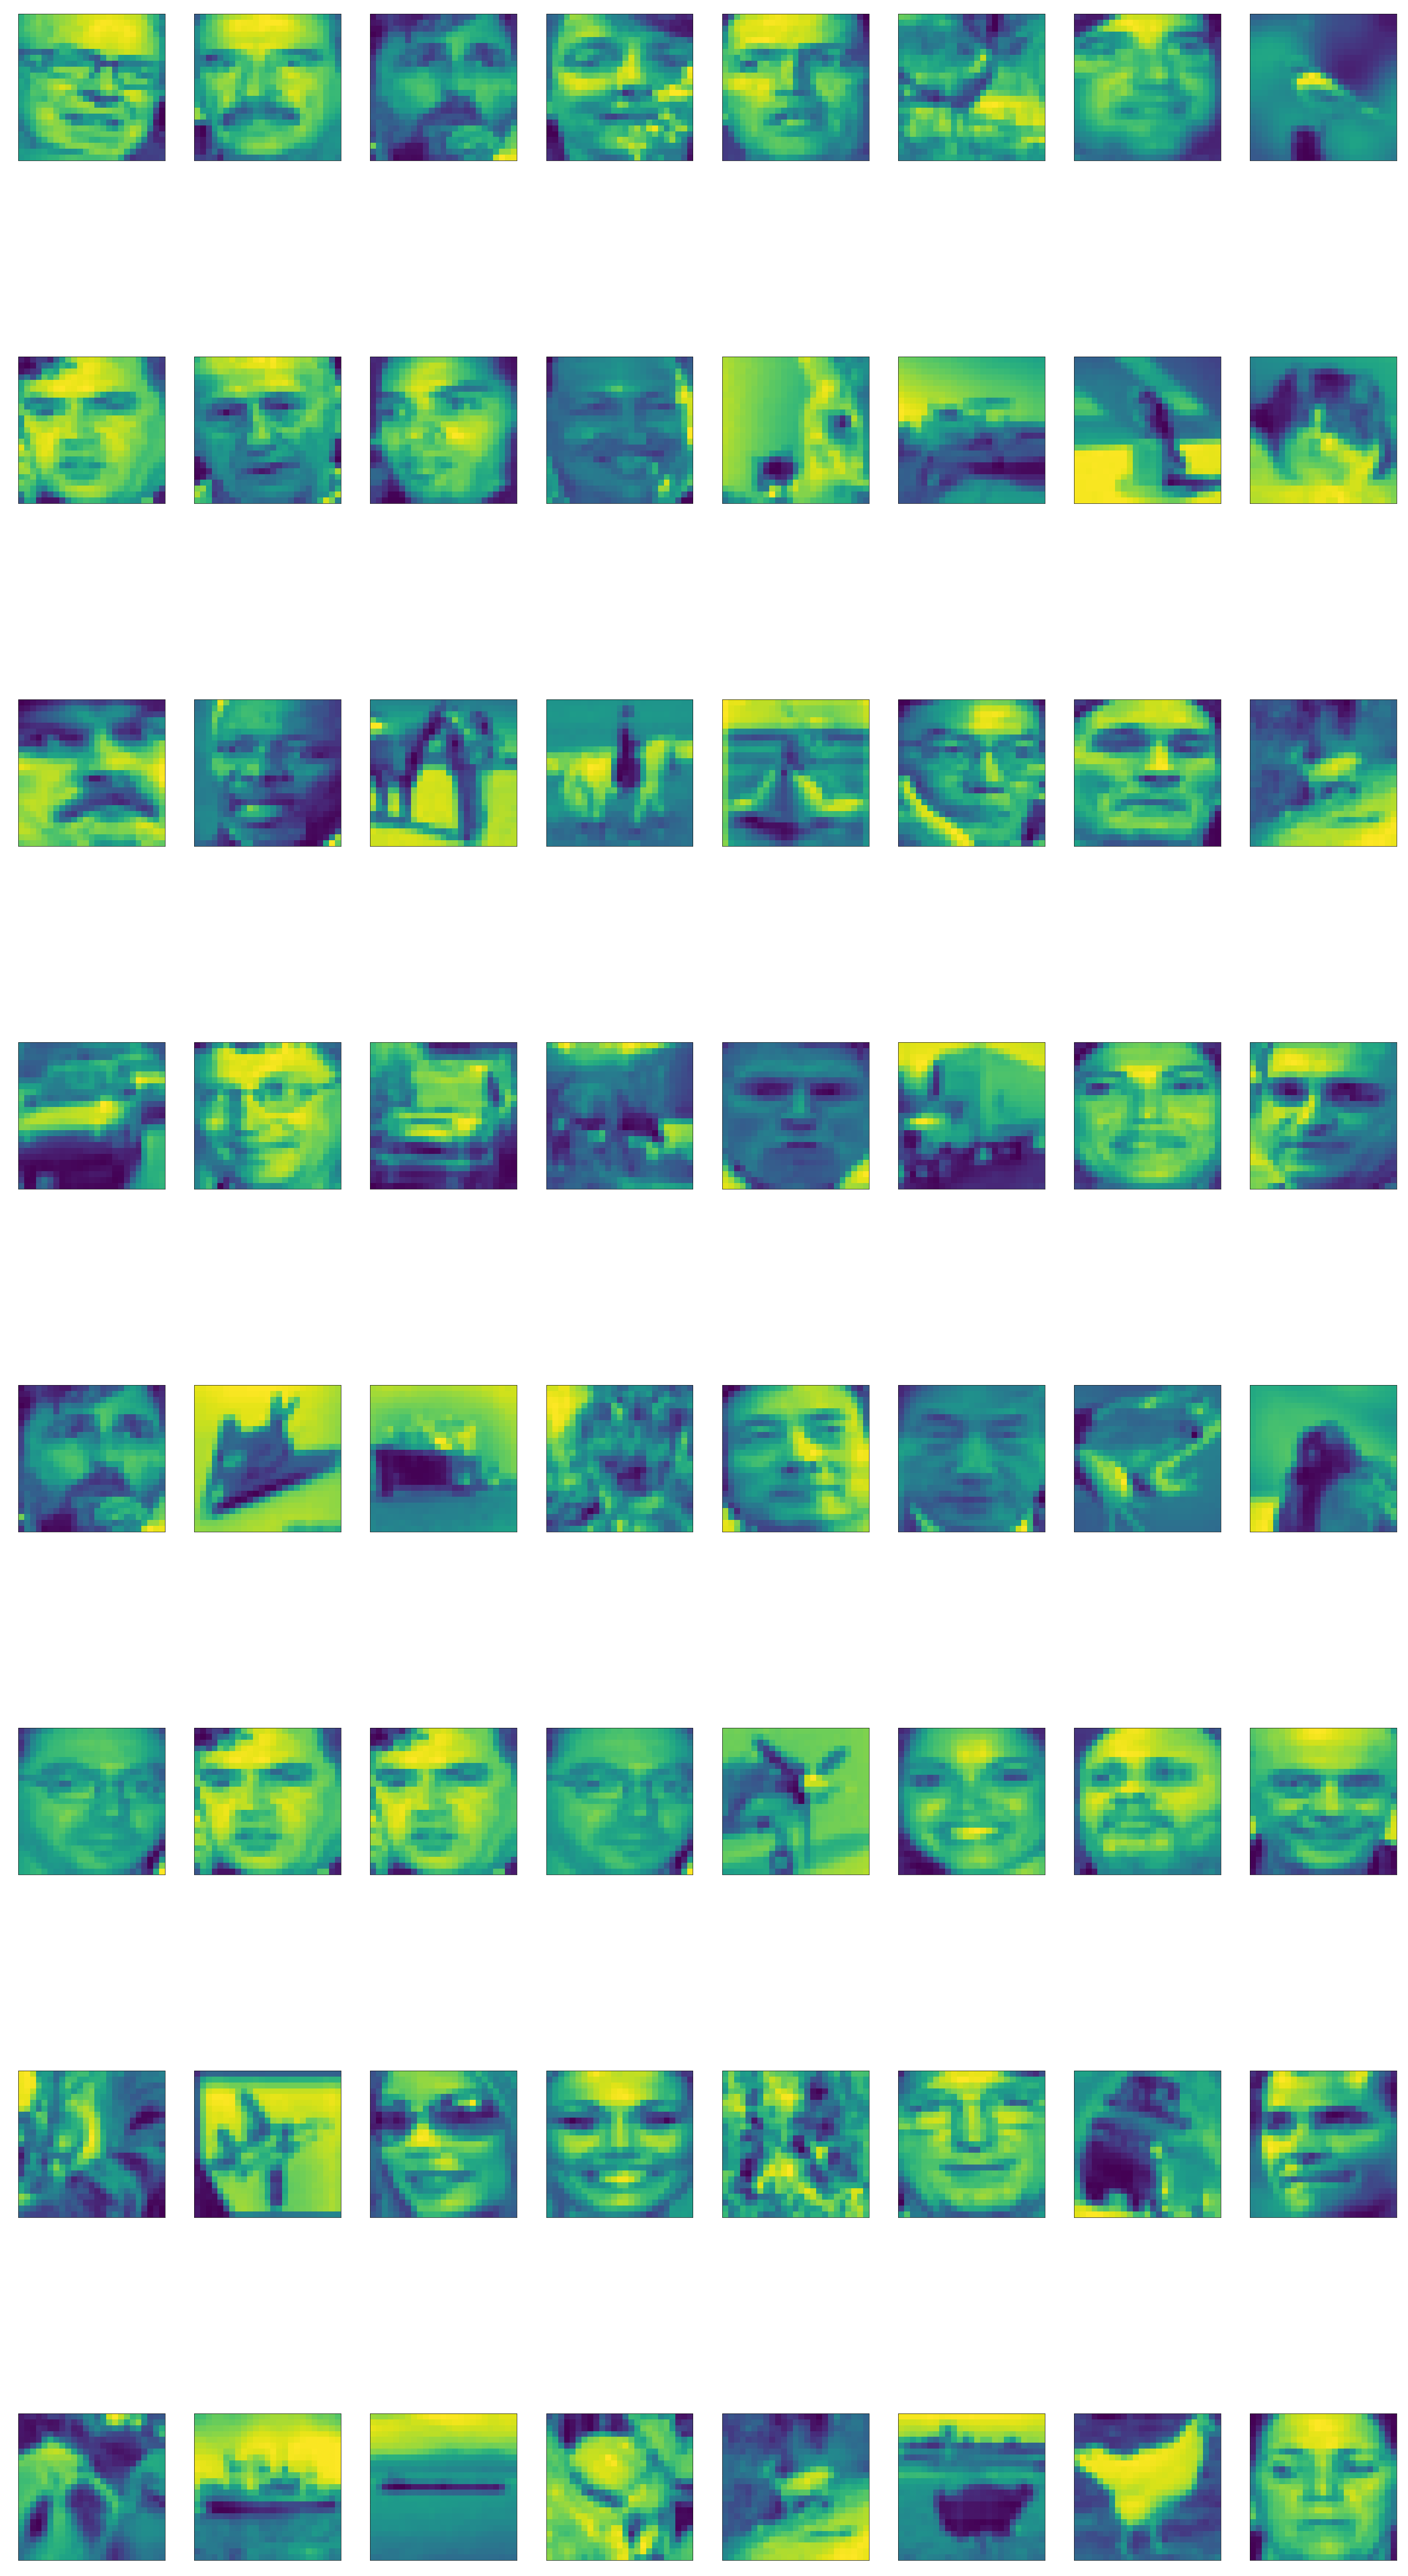

In [ ]:
indices = np.random.randint(0,dataset.shape[0],500)
data = dataset[indices,:,:]
Y = Y_dataset[indices]

fig, axs = plt.subplots(8, 8,figsize=(10*5,100))
sample = np.random.randint(0,data.shape[0],64)

for i in range(64):
    idx = sample[i]
    im=data[idx,...]
    axs[i//8,i%8].imshow(im)
    if Y[idx]==1:
        axs[i//8,i%8].set_title("{} min: {:.2f} max: {:.2f}".format("FACE",np.min(im),np.max(im)))
    else:
        axs[i//8,i%8].set_title("{} min: {:.2f} max: {:.2f}".format("NOT Face",np.min(im),np.max(im)))


In [ ]:
from tqdm.notebook import tqdm
features_edge_horizontal = list()
features_edge_vertical = list()
features_line_horizontal = list()
features_line_vertical = list()
features = list()
hhs = [5]
wws = [5]
for i in tqdm(range(data.shape[0])):
    img = data[i,...]
    integral_img = np.cumsum(np.cumsum(img,axis=0),axis=1)

    image_features_edge_horizontal= list()
    image_features_edge_vertical = list()
    image_features_line_horizontal = list()
    image_features_line_vertical = list()

    for hh in hhs:
        for ww in wws:
            for rr in range(img.shape[0]-hh):
                for cc in range(img.shape[1]-ww):
                    edge_vertical = edge_feature(integral_img,rr,cc,hh,ww)
                    edge_horizontal = edge_feature(integral_img,rr,cc,hh,ww,isVertical=False)
                    line_vertical  = line_feature(integral_img,rr,cc,hh,ww)
                    line_horizontal  = line_feature(integral_img,rr,cc,hh,ww,isVertical=False)

                    image_features_edge_horizontal+= [edge_horizontal]
                    image_features_edge_vertical+= [edge_vertical]
                    image_features_line_horizontal+= [line_horizontal]
                    image_features_line_vertical+= [line_vertical]


    features_edge_horizontal +=[image_features_edge_horizontal]
    features_edge_vertical+=[image_features_edge_vertical]
    features_line_horizontal+=[image_features_line_horizontal]
    features_line_vertical+=[image_features_line_vertical]

    features+= [image_features_edge_horizontal+image_features_edge_vertical
                +image_features_line_horizontal+image_features_line_vertical]

lr=1
clf = AdaBoostClassifier(n_estimators=1,learning_rate=lr)
clf.fit(features, Y)
print(clf.score(features, Y))

clf1 = AdaBoostClassifier(n_estimators=5,learning_rate=lr)
clf1.fit(features, Y)
print(clf1.score(features, Y))

clf2 = AdaBoostClassifier(n_estimators=25,learning_rate=lr)
clf2.fit(features, Y)
print(clf2.score(features, Y))

clf3 = AdaBoostClassifier(n_estimators=50,learning_rate=lr)
clf3.fit(features, Y)
print(clf3.score(features, Y))

  0%|          | 0/500 [00:00<?, ?it/s]

0.832
0.916
1.0
1.0


  0%|          | 0/18 [00:00<?, ?it/s]

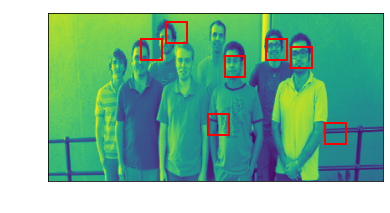

In [ ]:
img_orig = transform.resize(rgb2gray(io.imread("img/faces.jpg")),(200,400))
img_faces = np.cumsum(np.cumsum(img_orig,axis=0),axis=1)
fig, ax = plt.subplots()
ax.imshow(img_orig)
step = 10
for i in tqdm(np.arange(0,img_faces.shape[0]-25,step)):
    for j in np.arange(0,img_faces.shape[1]-25,step):
        integral_img = img_faces[i:i+25,j:j+25]
        feats = list()
        image_features_edge_horizontal= list()
        image_features_edge_vertical = list()
        image_features_line_horizontal = list()
        image_features_line_vertical = list()

        for hh in hhs:
            for ww in wws:
                for rr in range(img.shape[0]-hh):
                    for cc in range(img.shape[1]-ww):
                        edge_vertical = edge_feature(integral_img,rr,cc,hh,ww)
                        edge_horizontal = edge_feature(integral_img,rr,cc,hh,ww,isVertical=False)
                        line_vertical  = line_feature(integral_img,rr,cc,hh,ww)
                        line_horizontal  = line_feature(integral_img,rr,cc,hh,ww,isVertical=False)

                        image_features_edge_horizontal+= [edge_horizontal]
                        image_features_edge_vertical+= [edge_vertical]
                        image_features_line_horizontal+= [line_horizontal]
                        image_features_line_vertical+= [line_vertical]
        feature = image_features_edge_horizontal+image_features_edge_vertical\
                 +image_features_line_horizontal+image_features_line_vertical

        if clf.predict([feature]):
            if clf1.predict([feature]):
                if clf2.predict([feature]):
                    if clf3.predict([feature]):
                        rect = patches.Rectangle((j, i), 25, 25, linewidth=2, edgecolor='r', facecolor='none')
                        ax.add_patch(rect)

# D.U. naprogramovat diagonalnu haarovsku crtu a klasifikovat tvare cez adaboost